In [2]:
from pathlib import Path
from glob import glob

In [3]:
import numpy as np
import pandas as pd

import datasets

In [4]:
participants = [Path(file).name for file in glob('./data/ecg_preprocessed/*.csv')]

In [5]:
dataset = datasets.load_dataset(
    './data/ecg_preprocessed', 
    train_participants=participants,
    trust_remote_code=True,
    num_proc=8
)['fit']

Loading dataset shards:   0%|          | 0/291 [00:00<?, ?it/s]

In [6]:
import matplotlib.pyplot as plt

In [7]:
import neurokit2 as nk

In [8]:
plt.rcParams["figure.figsize"] = (10,3)

In [7]:
best_quality = dataset.filter(lambda ECG_Quality: [quality >= .99 for quality in ECG_Quality], batched=True, input_columns='ECG_Quality', batch_size=2048, num_proc=8)
len(best_quality)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



Filter (num_proc=8):   0%|          | 0/979678000 [00:00<?, ? examples/s]

402016429

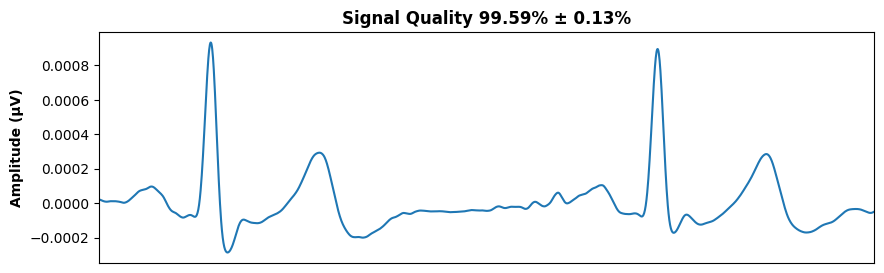

In [27]:
window = 1.25
window_size = 2*1000

df = pd.DataFrame(best_quality[int((window-1)*window_size):int(((window-1)*window_size)+window_size)])

plt.plot(df['timestamp'], df['ECG_Clean'])
plt.title(f"Signal Quality {round(df['ECG_Quality'].mean() * 100, 2)}% ± {round(df['ECG_Quality'].std() * 100, 2)}%", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.xticks([])
plt.xlim(df['timestamp'].min(), df['timestamp'].max())
plt.show()

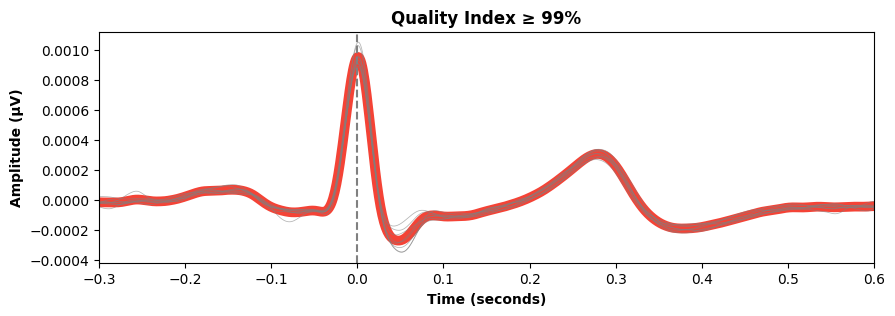

In [25]:
epochs = nk.ecg_segment(best_quality[:10000]["ECG_Clean"], rpeaks=None, sampling_rate=1000, show=True)
plt.title("Quality Index ≥ 99%", fontweight='bold')
plt.xlabel("Time (seconds)", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.3, 0.6)
plt.show()

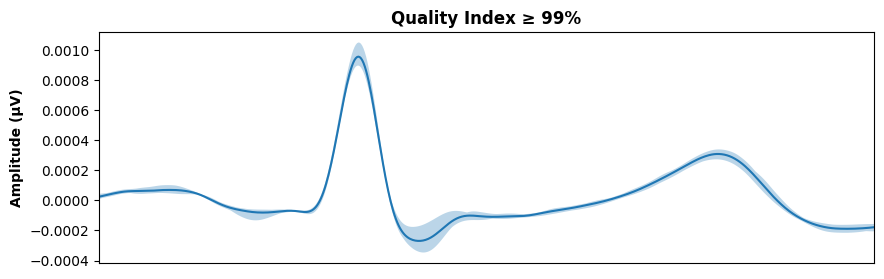

In [26]:
nk.epochs_average(epochs, which="Signal", show=True)
plt.title("Quality Index ≥ 99%", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.2, 0.4)
plt.xticks([])
plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [9]:
from tqdm import tqdm

In [10]:
import cupy as cp

## Test

In [11]:
from joblib import Parallel, delayed

In [12]:
participants = glob('./data/ecg_preprocessed/*.csv')

In [13]:
df = pd.read_csv(
    participants[0], 
    usecols=['ECG_Quality']
)

In [14]:
def get_quality_bins(path):
    df = pd.read_csv(
        path, 
        usecols=['ECG_Quality']
    )
    return (df * 100).round().astype(int).value_counts()

In [15]:
data = Parallel(n_jobs=8)(delayed(get_quality_bins)(path) for path in participants)

KeyboardInterrupt: 

In [ ]:
df = pd.concat(data, axis=1).sum(axis=1).astype(int)

In [ ]:
df = df.reset_index().rename(columns={0: 'count', 'ECG_Quality': 'quality'})

In [ ]:
bins_df = df[(df.quality >= 0) & (df.quality <= 100)].sort_values('quality', ascending=False)

In [ ]:
bins_df.loc[bins_df.quality == 100, 'count'] += df[df.quality > 100]['count'].sum()
bins_df.loc[bins_df.quality == 0, 'count'] += df[df.quality < 0]['count'].sum()
bins_df

,quality,count
0,100,247392470
1,99,256743842
2,98,122151583
3,97,74738662
4,96,53214895
...,...,...
96,4,9342
95,3,9274
94,2,9899
93,1,10967


In [ ]:
bins_df['percentage'] = (bins_df['count']/bins_df['count'].sum()) * 100

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

In [ ]:
cm = plt.cm.get_cmap('RdYlGn')

C:\Users\Admin\AppData\Local\Temp\ipykernel_19676\420927935.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlGn')


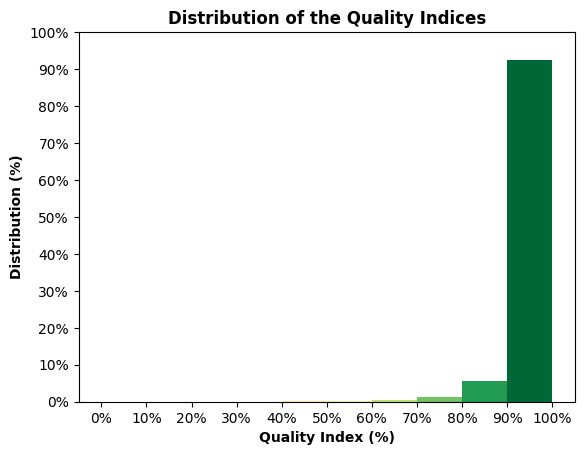

In [66]:
n, bins, patches = plt.hist(bins_df['quality'], bins=10, weights=bins_df['percentage'])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 101, 10))
plt.gca().set_xticklabels([f'{int(x)}%' for x in plt.gca().get_xticks()]) 
plt.gca().set_yticklabels([f'{x}%' for x in plt.gca().get_yticks()]) 

plt.xlabel("Quality Index (%)", fontweight='bold')
plt.ylabel("Distribution (%)", fontweight='bold')

plt.title("Distribution of the Quality Indices", fontweight='bold')

plt.show()

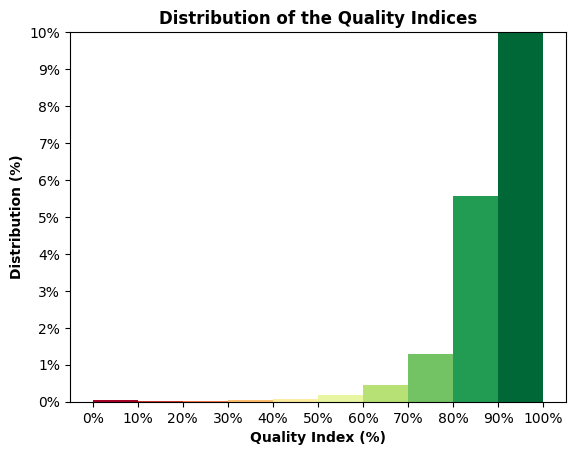

In [67]:
n, bins, patches = plt.hist(bins_df['quality'], bins=10, weights=bins_df['percentage'])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
plt.ylim(0, 10)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 11, 1))
plt.gca().set_xticklabels([f'{int(x)}%' for x in plt.gca().get_xticks()]) 
plt.gca().set_yticklabels([f'{x}%' for x in plt.gca().get_yticks()]) 

plt.xlabel("Quality Index (%)", fontweight='bold')
plt.ylabel("Distribution (%)", fontweight='bold')

plt.title("Distribution of the Quality Indices", fontweight='bold')

plt.show()

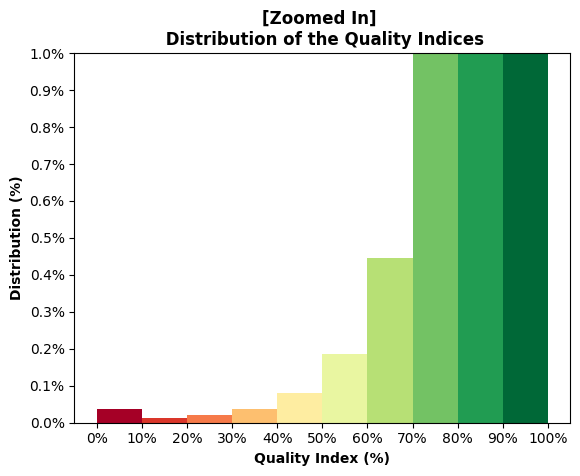

In [68]:
n, bins, patches = plt.hist(bins_df['quality'], bins=10, weights=bins_df['percentage'])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
plt.ylim(0, 1)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().set_xticklabels([f'{int(x)}%' for x in plt.gca().get_xticks()]) 
plt.gca().set_yticklabels([f'{round(x, 1)}%' for x in plt.gca().get_yticks()]) 

plt.xlabel("Quality Index (%)", fontweight='bold')
plt.ylabel("Distribution (%)", fontweight='bold')

plt.title("[Zoomed In] \n Distribution of the Quality Indices", fontweight='bold')
plt.show()

## Plots per Bucket

In [16]:
import neurokit2 as nk

In [17]:
high_quality = dataset.filter(lambda ECG_Quality: [quality >= .75 for quality in ECG_Quality], batched=True, input_columns='ECG_Quality', batch_size=2048, num_proc=8)
len(high_quality)

Filter (num_proc=8):   0%|          | 0/979678000 [00:00<?, ? examples/s]

966508218

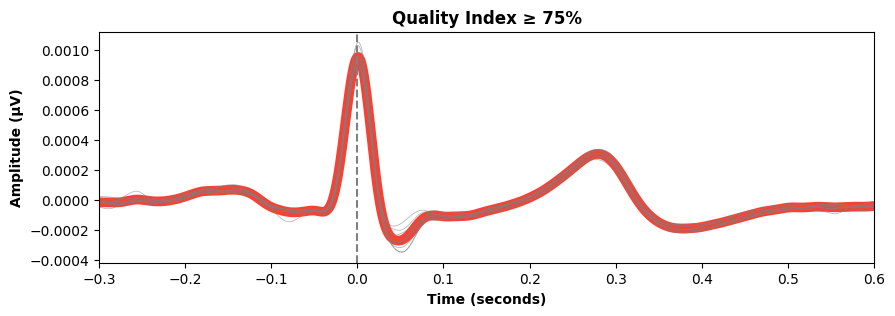

In [18]:
epochs = nk.ecg_segment(high_quality[:10000]["ECG_Clean"], rpeaks=None, sampling_rate=1000, show=True)
plt.title("Quality Index ≥ 75%", fontweight='bold')
plt.xlabel("Time (seconds)", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.3, 0.6)
plt.show()

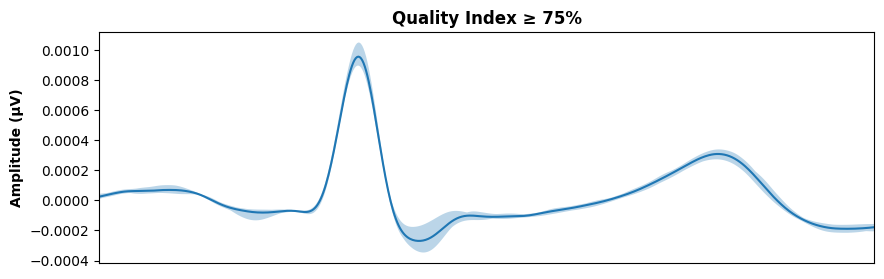

In [19]:
nk.epochs_average(epochs, which="Signal", show=True)
plt.title("Quality Index ≥ 75%", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.2, 0.4)
plt.xticks([])
plt.show()

In [9]:
moderate_quality = dataset.filter(lambda ECG_Quality: [quality >= .50 and quality < .75 for quality in ECG_Quality], batched=True, input_columns='ECG_Quality', batch_size=2048, num_proc=8)
len(moderate_quality)

11260355

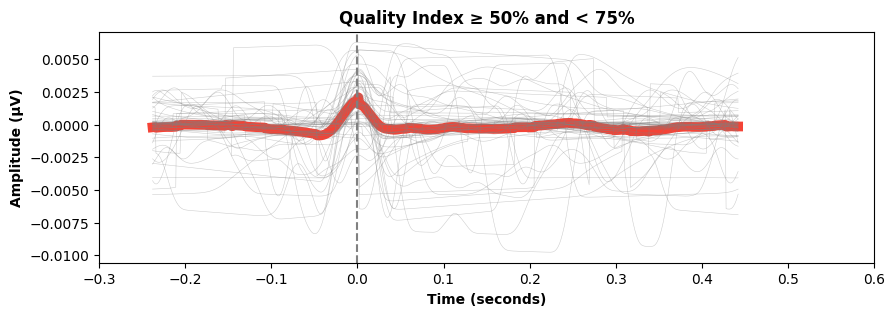

In [12]:
epochs = nk.ecg_segment(moderate_quality[:40000]["ECG_Clean"], rpeaks=None, sampling_rate=1000, show=True)
plt.title("Quality Index ≥ 50% and < 75%", fontweight='bold')
plt.xlabel("Time (seconds)", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.3, 0.6)
plt.show()

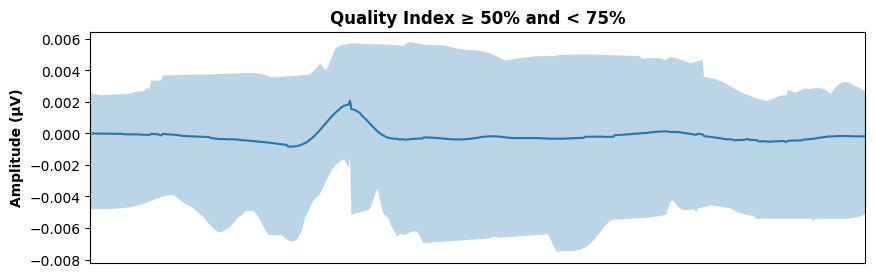

In [13]:
nk.epochs_average(epochs, which="Signal", show=True)
plt.title("Quality Index ≥ 50% and < 75%", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.2, 0.4)
plt.xticks([])
plt.show()

In [14]:
low_quality = dataset.filter(lambda ECG_Quality: [quality > .25 and quality < .50 for quality in ECG_Quality], batched=True, input_columns='ECG_Quality', batch_size=2048, num_proc=8)
len(low_quality)

Filter (num_proc=8):   0%|          | 0/979678000 [00:00<?, ? examples/s]

1324697

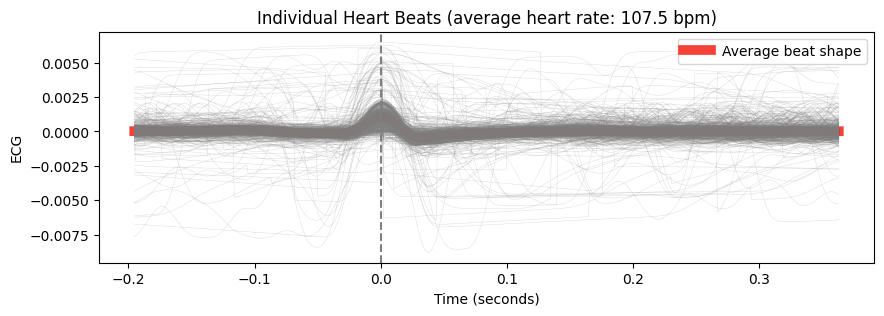

In [ ]:
epochs = nk.ecg_segment(low_quality[:10000]["ECG_Clean"], rpeaks=None, sampling_rate=1000, show=True)
plt.title("Quality Index > 25% and < 50%", fontweight='bold')
plt.xlabel("Time (seconds)", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.3, 0.6)
plt.show()

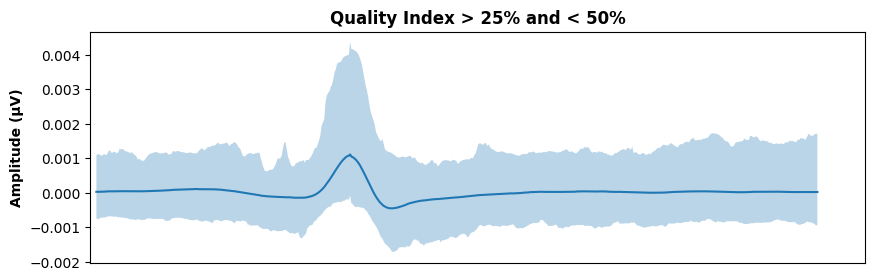

In [ ]:
nk.epochs_average(epochs, which="Signal", show=True)
plt.title("Quality Index > 25% and < 50%", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.2, 0.4)
plt.xticks([])
plt.show()

In [ ]:
trash_quality = dataset.filter(lambda ECG_Quality: [quality <= .25 for quality in ECG_Quality], batched=True, input_columns='ECG_Quality', batch_size=2048, num_proc=8)
len(trash_quality)

584730

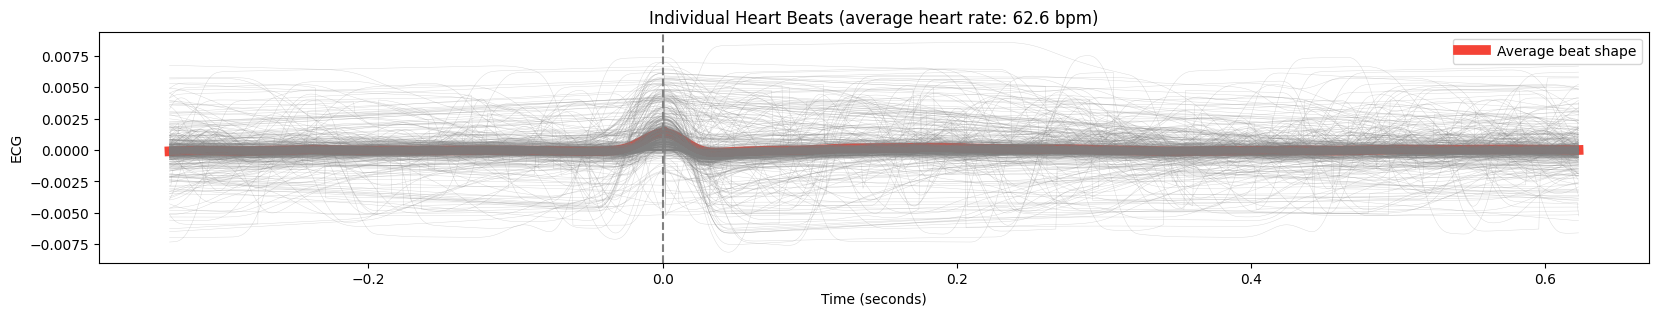

In [ ]:
epochs = nk.ecg_segment(trash_quality[:10000]["ECG_Clean"], rpeaks=None, sampling_rate=1000, show=True)
plt.title("Quality Index ≤ 25%", fontweight='bold')
plt.xlabel("Time (seconds)", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.3, 0.6)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)

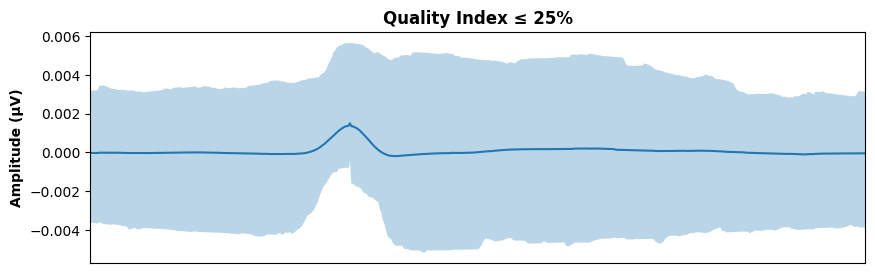

In [ ]:
nk.epochs_average(epochs, which="Signal", show=True)
plt.title("Quality Index ≤ 25%", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.2, 0.4)
plt.xticks([])
plt.show()

In [ ]:
ultra_bad_quality = dataset.filter(lambda ECG_Quality: [quality <= .2 for quality in ECG_Quality], batched=True, input_columns='ECG_Quality', batch_size=2048, num_proc=8)
len(ultra_bad_quality)

Filter (num_proc=8):   0%|          | 0/979678000 [00:00<?, ? examples/s]

492886

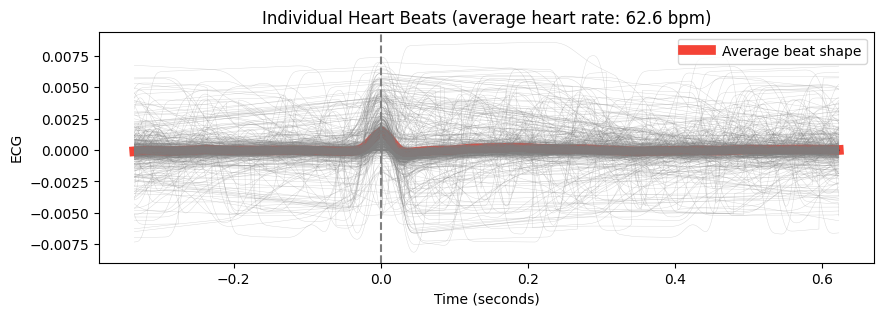

In [ ]:
epochs = nk.ecg_segment(trash_quality[:10000]["ECG_Clean"], rpeaks=None, sampling_rate=1000, show=True)
plt.title("Quality Index ≤ 20%", fontweight='bold')
plt.xlabel("Time (seconds)", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.3, 0.6)
plt.show()

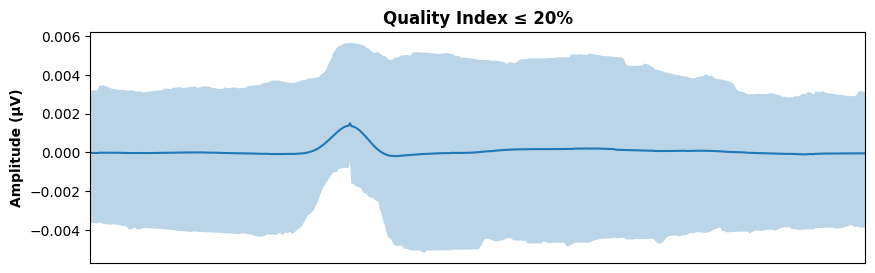

In [ ]:
nk.epochs_average(epochs, which="Signal", show=True)
plt.title("Quality Index ≤ 20%", fontweight='bold')
plt.ylabel("Amplitude (µV)", fontweight='bold')
plt.legend('',frameon=False)
plt.xlim(-0.2, 0.4)
plt.xticks([])
plt.show()